# Building a Neural Network from Scratch

https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65 

### Abstract Base Class : Layer
The abstract class Layer, which all other layers will inherit from, handles simple properties which are an input, an output, and both a forward and backward methods.

In [5]:

# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In the abstract class above, backward_propagation function has an extra parameter, learning_rate, which is controlling the amount of learning/updating parameters using gradient descent.

### Backward Propagation
Suppose we have a matrix containing the derivative of the error with respect to that layer’s output: $\frac{\partial E}{\partial Y}$

We need :
- The derivative of the error with respect to the parameters ($\frac{\partial E}{\partial W}$, $\frac{\partial E}{\partial B}$)
- The derivative of the error with respect to the input ($\frac{\partial E}{\partial X}$)

Let's calculate $\frac{\partial E}{\partial W}$. This matrix should be the same size as $W$ itself : 

$i x j$ where $i$ is the number of input neurons and $j$ the number of output neurons. We need one gradient for every weight

### Coding the Fully Connected Layer

In [6]:
#from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of edges that connects to neurons in next layer
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

### Activation Layer
All the calculation we did until now were completely linear, may not learn well. We need to add non-linearity to the model by applying non-linear functions to the output of some layers.

Now we need to redo the whole process for this new type of layer!

In [7]:
#from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        return self.activation_prime(self.input) * output_error

You can also write some activation functions and their derivatives in a separate file. These will be used later to create an ActivationLayer.

In [8]:
import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

Part 1

In [19]:
import numpy as np

#sigmoid activation function and its derivative
def sig(x):
  s=1 / (1 + np.exp(-x))
  return s

def sig_prime(x):
  s=1 / (1 + np.exp(-x))
  ds =s* (1-s)
  return ds

In [27]:
import numpy as np

#RelU activation function and its derivative
def relu(x):
  return max(0.0, x.any())

def relu_prime(x):
  return 1 if x.any() > 0 else 0


### Loss Function
Until now, for a given layer, we supposed that ∂E/∂Y was given (by the next layer). But what happens to the last layer? How does it get ∂E/∂Y? We simply give it manually, and it depends on how we define the error.
The error of the network, which measures how good or bad the network did for a given input data, is defined by you. 

There are many ways to define the error, and one of the most known is called MSE — Mean Squared Error.

In [11]:

import numpy as np

# loss function and its derivative
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

### Network Class
Almost done ! We are going to make a Network class to create neural networks very easily using the building blocks we have prepared so far.


In [12]:
# example of a function for calculating softmax for a list of numbers
from numpy import exp
 
# calculate the softmax of a vector
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [13]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None

    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

        
    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network 
    
    def fit(self, x_train, y_train, epochs, learning_rate):
        '''
        Fit function does the training. 
        Training data is passed 1-by-1 through the network layers during forward propagation.
        Loss (error) is calculated for each input and back propagation is performed via partial 
        derivatives on each layer.
        '''
        # sample dimension first
        samples = len(x_train)

        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)

                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

### Building Neural Networks
Finally ! We can use our class to create a neural network with as many layers as we want ! We are going to build two neural networks : a simple XOR and a MNIST solver.


### Solve XOR
Starting with XOR is always important as it’s a simple way to tell if the network is learning anything at all.

In [ ]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network
net = Network()
net.add(FCLayer(2, 3))
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(3, 1))
net.add(ActivationLayer(tanh, tanh_prime))

# train
net.use(mse, mse_prime)
net.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

Part 1 implementation

In [ ]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import sig, sig prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network using sigmoid activation function
net_sig = Network()
net_sig.add(FCLayer(2, 3))
net_sig.add(ActivationLayer(sig, sig_prime))
net_sig.add(FCLayer(3, 1))
net_sig.add(ActivationLayer(sig, sig_prime))

# train
net_sig.use(mse, mse_prime)
net_sig.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

In [ ]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import relu, relu prime
#from losses import mse, mse_prime

# training data
x_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

# network using relu activation function
net_relu = Network()
net_relu.add(FCLayer(2, 3))
net_relu.add(ActivationLayer(relu, relu_prime))
net_relu.add(FCLayer(3, 1))
net_relu.add(ActivationLayer(relu, relu_prime))

# train
net_relu.use(mse, mse_prime)
net_relu.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

### Solve MNIST
We didn’t implemented the Convolutional Layer but this is not a problem. 
All we need to do is to reshape our data so that it can fit into a Fully Connected Layer.
MNIST Dataset consists of images of digits from 0 to 9, of shape 28x28x1. 
The goal is to predict what digit is drawn on a picture.

In [ ]:
import numpy as np

#from network import Network
#from fc_layer import FCLayer
#from activation_layer import ActivationLayer
#from activations import tanh, tanh_prime
#from losses import mse, mse_prime

from keras.datasets import mnist
from keras.utils import np_utils

# load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 1, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)

# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 1, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)

# Network
net = Network()
net.add(FCLayer(28*28, 100))                # input_shape=(1, 28*28)    ;   output_shape=(1, 100)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(100, 50))                   # input_shape=(1, 100)      ;   output_shape=(1, 50)
net.add(ActivationLayer(tanh, tanh_prime))
net.add(FCLayer(50, 10))                    # input_shape=(1, 50)       ;   output_shape=(1, 10)
net.add(ActivationLayer(tanh, tanh_prime))

# train on 1000 samples
# as we didn't implemented mini-batch GD, training will be pretty slow if we update at each iteration on 60000 samples...
net.use(mse, mse_prime)
net.fit(x_train[0:1000], y_train[0:1000], epochs=35, learning_rate=0.1)

# test on 3 samples
out = net.predict(x_test[0:3])
print("\n")
print("predicted values : ")
print(out, end="\n")
print("true values : ")
print(y_test[0:3])

11493376/11490434 [==============================] - 4s 0us/step
epoch 1/35   error=0.214189
epoch 2/35   error=0.101278
epoch 3/35   error=0.079496
epoch 4/35   error=0.065394
epoch 5/35   error=0.055682
epoch 6/35   error=0.048296
epoch 7/35   error=0.042828
epoch 8/35   error=0.038248
epoch 9/35   error=0.034382
epoch 10/35   error=0.031348
epoch 11/35   error=0.028500
epoch 12/35   error=0.026354
epoch 13/35   error=0.024293
epoch 14/35   error=0.022745
epoch 15/35   error=0.021340
epoch 16/35   error=0.020143
epoch 17/35   error=0.018965
epoch 18/35   error=0.017846
epoch 19/35   error=0.016617
epoch 20/35   error=0.015530
epoch 21/35   error=0.014574
epoch 22/35   error=0.013843
epoch 23/35   error=0.013127
epoch 24/35   error=0.012640
epoch 25/35   error=0.012170
epoch 26/35   error=0.011867
epoch 27/35   error=0.011442
epoch 28/35   error=0.011101
epoch 29/35   error=0.010712
epoch 30/35   error=0.010382
epoch 31/35   error=0.010013
epoch 32/35   error=0.009720
epoch 33/35   er

In [ ]:
print(x_test[0:3])

[[[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]]]


Part 3 (Data Set)

In [29]:
import pandas as pd
# Load data as Pandas dataframe
train = pd.read_csv('/content/train_clean.csv', )
test = pd.read_csv('/content/test_clean.csv')
df = pd.concat([train, test], axis=0, sort=True)

In [30]:
df.head()

,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Mr
1,38.0,C85,C,1,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Mrs
2,26.0,NaN,S,0,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Miss
3,35.0,C123,S,1,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Mrs
4,35.0,NaN,S,0,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Mr


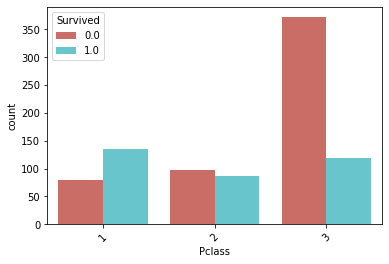

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Pclass', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

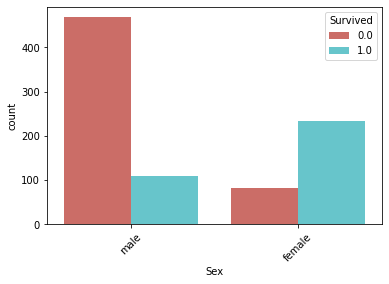

In [32]:
sns.countplot(x='Sex', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

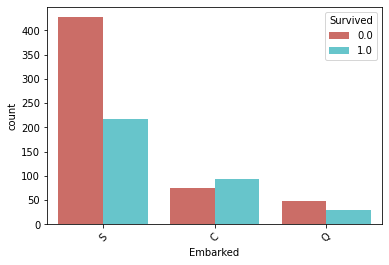

In [33]:
sns.countplot(x='Embarked', data=df, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [34]:
# convert to cateogry dtype
df['Sex'] = df['Sex'].astype('category')
# convert to category codes
df['Sex'] = df['Sex'].cat.codes

In [35]:
# subset all categorical variables which need to be encoded
categorical = ['Embarked', 'Title']

for var in categorical:
    df = pd.concat([df, 
                    pd.get_dummies(df[var], prefix=var)], axis=1)
    del df[var]

In [36]:
# drop the variables we won't be using
df.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [37]:
df.head()

,Age,Family_Size,Fare,Parch,Pclass,Sex,SibSp,Survived,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,22.0,1,7.2500,0,3,1,1,0.0,0,0,1,0,0,0,1,0,0
1,38.0,1,71.2833,0,1,0,1,1.0,1,0,0,0,0,0,0,1,0
2,26.0,0,7.9250,0,3,0,0,1.0,0,0,1,0,0,1,0,0,0
3,35.0,1,53.1000,0,1,0,1,1.0,0,0,1,0,0,0,0,1,0
4,35.0,0,8.0500,0,3,1,0,0.0,0,0,1,0,0,0,1,0,0


In [38]:
import numpy as np

# training data
X_train = df[pd.notnull(df['Survived'])].drop(['Survived'], axis=1)
y_train = df[pd.notnull(df['Survived'])]['Survived']
X_test = df[pd.isnull(df['Survived'])].drop(['Survived'], axis=1)

# network using relu activation function
net_ds = Network()
net_ds.add(FCLayer(14, 20))
net_ds.add(ActivationLayer(relu, relu_prime))
net_ds.add(FCLayer(20, 1))
net_ds.add(ActivationLayer(relu, relu_prime))

# train
net_ds.use(mse, mse_prime)
net_ds.fit(x_train, y_train, epochs=1000, learning_rate=0.1)

# test
out = net.predict(x_train)
print(out)

ValueError: ignored